<a href="https://colab.research.google.com/github/vishalraut88/BERT_Models/blob/main/BERT_disaster_Tweet_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 25.90 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [2]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.1/215.1 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 18.5 MB/s eta 0

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [4]:
train_df,remaining =train_test_split(train_data,random_state=42,test_size=0.2,stratify=train_data.target.values) 
valid_df,test_df=train_test_split(remaining,random_state=42,test_size=0.5,stratify=remaining.target.values)

#### Step 1 : Convert input data(/frame) to tensor slices

In [5]:
tf_train_data = tf.data.Dataset.from_tensor_slices((train_df.text.values,train_df.target.values))
tf_test_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values,valid_df.target.values))

In [6]:
for text,label in tf_train_data.take(5):
  print(text)
  print(label)

tf.Tensor(b'Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/nkKcTttsD9 #ibooklove #bookboost', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"God's Kingdom (Heavenly Gov't) will rule over all people on the earth after Armageddon.  http://t.co/8HGcBXUkz0  http://t.co/4kopkCyvTt", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Mopheme and Bigstar Johnson are a problem in this game body bagging niggas #VuzuHustle', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'@VixMeldrew sounds like a whirlwind life!', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Malaysia confirms plane debris washed up on Reunion Island is from Flight MH370 http://t.co/YS3WALzvjg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


#### Step 2 : Import bert layer and instantiate tokenizer object


In [7]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',trainable=True)
label_list=[0,1]
max_seq_length = 128
train_batch_size=32

In [8]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file=vocab_file,do_lower_case=do_lower_case)
# tokens = tokenizer.wordpiece_tokenizer.tokenize("hi,How are you ")
# tokenizer.convert_tokens_to_ids(tokens)

#### Step 3 : Bert preprocessing 
1. InputExamples
2. Map function

In [9]:
example=classifier_data_lib.InputExample(
                                  guid=None,
                                  text_a="hi,how are you",
                                  text_b=None,
                                  label=1
                                  )
features = classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length,tokenizer)
print(features.input_ids)
print(features.input_mask)
print(features.segment_ids)
print(features.label_id)

[101, 7632, 1010, 2129, 2024, 2017, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
def get_features(text, ip_label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,text_a=text,text_b=None,label=ip_label)
  features = classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length,tokenizer)
  return (features.input_ids,features.input_mask,features.segment_ids,features.label_id)
  

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

#### Step 3 : Wrap the get features function in pytorcj

In [11]:
# from tensorflow._api.v2.compat.v1 import py_function
def get_features_map(text,label):
  input_ids,mask_ids,segment_ids,label_id=tf.py_function(get_features,inp=[text,label],
                                                         Tout=[tf.int32,tf.int32,tf.int32,tf.int32])

  #### Shape of the output tensor is not implicitly set by wrapper function
  #### so we have to manually set the shape.
  input_ids.set_shape([max_seq_length])
  mask_ids.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])

  label_id.set_shape([])
  features_dict= {'input_word_ids':input_ids,
                  'input_mask':mask_ids,
                  'input_type_ids':segment_ids
                  }

  return (features_dict,label_id)
  



In [12]:
tf_train_data = (tf_train_data.map(get_features_map,
                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
                  .shuffle(1000)
                  .batch(32,drop_remainder=True)
                  .prefetch(tf.data.experimental.AUTOTUNE)
)


tf_test_data = (tf_test_data.map(get_features_map,
                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
                  .shuffle(1000)
                  .batch(32,drop_remainder=True)
                  .prefetch(tf.data.experimental.AUTOTUNE)
)

In [13]:
# train data spec
tf_train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [14]:
# train data spec
tf_test_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

#### Step 4 :Build classifier NN using Bert layer

In [15]:
def build_NN_model():
  input_ids= tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32,name="input_ids")
  mask_ids= tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32,name="mask_ids")
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32,name="input_type_ids")

  pooled_output,sequence_output=bert_layer([input_ids,mask_ids,input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1,activation="sigmoid")(drop)
  model = tf.keras.Model(
      inputs={
          "input_word_ids":input_ids,
          "input_mask":mask_ids,
          "input_type_ids":input_type_ids
      },
      outputs=output
  )
  return model


In [16]:
model = build_NN_model()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

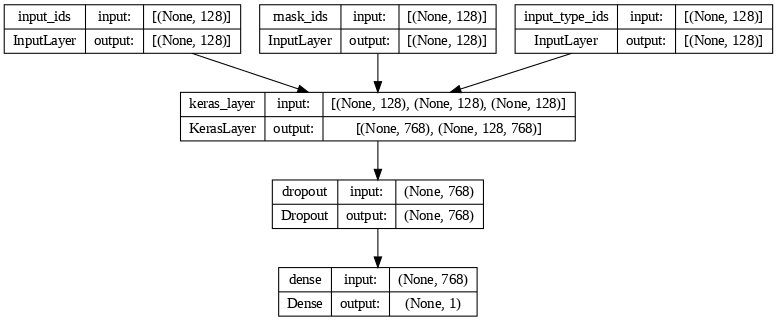

In [18]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [19]:
# Train model
epochs=4
history=model.fit(tf_train_data,validation_data=tf_test_data,
                  epochs=epochs,verbose=1)

Epoch 1/4


InvalidArgumentError: ignored